<a id='top'></a>
<div class="list-group" id="list-tab" role="tablist">
<h1 style='background:#fad25a;padding-top:17px; border:0; color:black'><center>Content</center></h1> 

[1. Imports](#1)
    
[2. Data Preprocessing](#2)    

[3. Model Implementations](#3)     

[4. Transfer Learning](#4)     
    
[5. Evaluation ](#5)
    
[6. Conclusion](#6)   
 <a id="1"></a>
<h1 style='background:#fad25a;padding-top:17px; border:0; color:black'><center>Imports</center></h1> 
    
# Imports

In [1]:
import os
import shutil
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import random
import plotly.express as px
import cv2 as cv2

from shutil import copyfile
from tensorflow.keras.layers import Conv2D,Add,MaxPooling2D, Dense, BatchNormalization,Input,Flatten, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.preprocessing.image import ImageDataGenerator 

<a id="2"></a>
<h1 style='background:#fad25a;padding-top:17px; border:0; color:black'><center>Data Preprocessing</center></h1> 
    
# Data Preprocessing

In [2]:
class_names = ['Benign', 'G3', 'G4', 'G5'] 

# Define data path
BASE_DIR = '/kaggle/input/prostate-classification-ukm/Prostate/'
BENIGN_DIR = BASE_DIR + 'Benign'
G3_DIR = BASE_DIR + 'G3'
G4_DIR = BASE_DIR + 'G4'
G5_DIR = BASE_DIR + 'G5'
# Define data path
BENIGN_DIR = BASE_DIR + 'Benign'
G3_DIR = BASE_DIR + 'G3'
G4_DIR = BASE_DIR + 'G4'
G5_DIR = BASE_DIR + 'G5'

n_benign = len(os.listdir(BASE_DIR + 'Benign'))
n_g3 = len(os.listdir(BASE_DIR + 'G3'))
n_g4 = len(os.listdir(BASE_DIR + 'G4'))
n_g5 = len(os.listdir(BASE_DIR + 'G5'))
n_images = [n_benign, n_g3, n_g4, n_g5]
px.pie(names=class_names, values=n_images)

**Now let's create directories for training and validation**

In [3]:
try:
    os.mkdir('/tmp/prostate')
    os.mkdir('/tmp/prostate/training')
    os.mkdir('/tmp/prostate/validation')
    os.mkdir('/tmp/prostate/training/benign')
    os.mkdir('/tmp/prostate/training/g3')
    os.mkdir('/tmp/prostate/training/g4')
    os.mkdir('/tmp/prostate/training/g5')
    os.mkdir('/tmp/prostate/validation/benign')
    os.mkdir('/tmp/prostate/validation/g3')
    os.mkdir('/tmp/prostate/validation/g4')
    os.mkdir('/tmp/prostate/validation/g5')
except OSError:
    print('Error failed to make directory')

**Now let's create  a function to split the   data**

In [4]:
def split_data(main_dir, training_dir, validation_dir, split_size):
    """
    Splits the data into train and test sets

    Args:
    main_dir (string):  path containing the images
    training_dir (string):  path to be used for training
    validation_dir (string):  path to be used for validation
    split_size (float): size of the dataset to be used for training
    """
    files = []
    for file in os.listdir(main_dir):
        if  os.path.getsize(os.path.join(main_dir, file)): # check if the file's size isn't 0
            files.append(file) # appends file name to a list

    shuffled_files = random.sample(files,  len(files)) # shuffles the data
    split = int(0.9 * len(shuffled_files)) #the training split casted into int for numeric rounding

    train = shuffled_files[:split] #training split
    validation = shuffled_files[split:] # validation split

    for element in train:
        copyfile(os.path.join(main_dir,  element), os.path.join(training_dir, element)) # copy files into training directory

    for element in validation:
        copyfile(os.path.join(main_dir,  element), os.path.join(validation_dir, element))# copy files into validation directory

**Now let's call the function to create the  training/validation data**

In [5]:
TRAINING_DIR = "/tmp/prostate/training/"
VALIDATION_DIR = "/tmp/prostate/validation/"

In [6]:
split_data(BENIGN_DIR, TRAINING_DIR + 'benign', VALIDATION_DIR + 'benign', 0.9)
split_data(G3_DIR, TRAINING_DIR + 'g3', VALIDATION_DIR + 'g3', 0.9)
split_data(G4_DIR, TRAINING_DIR + 'g4', VALIDATION_DIR + 'g4', 0.9)
split_data(G5_DIR, TRAINING_DIR + 'g5', VALIDATION_DIR + 'g5', 0.9)

**As a sanity check let's check the data directories**

In [7]:
print(len(os.listdir(TRAINING_DIR + 'benign')))
print(len(os.listdir(TRAINING_DIR + 'g3')))
print(len(os.listdir(TRAINING_DIR + 'g4')))
print(len(os.listdir(TRAINING_DIR + 'g5')))

print(len(os.listdir(VALIDATION_DIR + 'benign')))
print(len(os.listdir(VALIDATION_DIR + 'g3')))
print(len(os.listdir(VALIDATION_DIR + 'g4')))
print(len(os.listdir(VALIDATION_DIR + 'g5')))

46
36
50
39
6
5
6
5


## Create Generators

In [8]:
train_datagen = ImageDataGenerator(rescale = 1./255.,
                                   rotation_range = 40,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)


valid_datagen = ImageDataGenerator( rescale = 1.0/255. )

# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(TRAINING_DIR,
                                                    batch_size = 64,
                                                    class_mode = 'binary', 
                                                    target_size = (150, 150))     


validation_generator =  valid_datagen.flow_from_directory(VALIDATION_DIR,
                                                          batch_size  = 64,
                                                          class_mode  = 'binary', 
                                                          target_size = (150, 150))

Found 171 images belonging to 4 classes.
Found 22 images belonging to 4 classes.


**Now let's visualize the data**

In [9]:
def plot_data(generator, n_images):
    """
    Plots random data from dataset
    Args:
    generator: a generator instance
    n_images : number of images to plot
    """
    i = 1
    images, labels = generator.next()
    labels = labels.astype('int32')

    plt.figure(figsize=(14, 15))
    
    for image, label in zip(images, labels):
        plt.subplot(4, 3, i)
        plt.imshow(image)
        plt.title(class_names[label])
        plt.axis('off')
        i += 1
        if i == n_images:
            break
    
    plt.show()

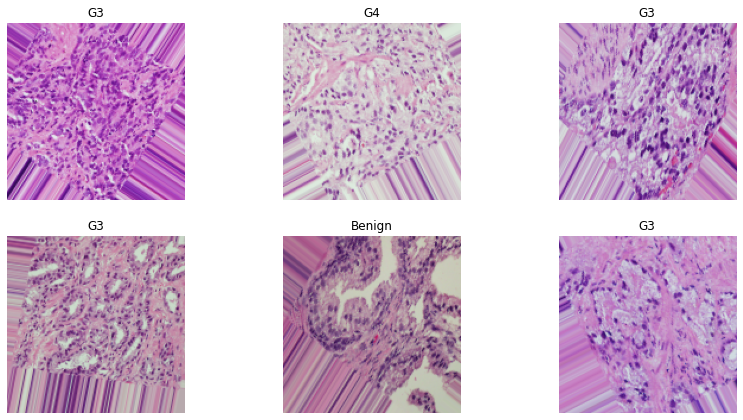

In [10]:
plot_data(train_generator,7)

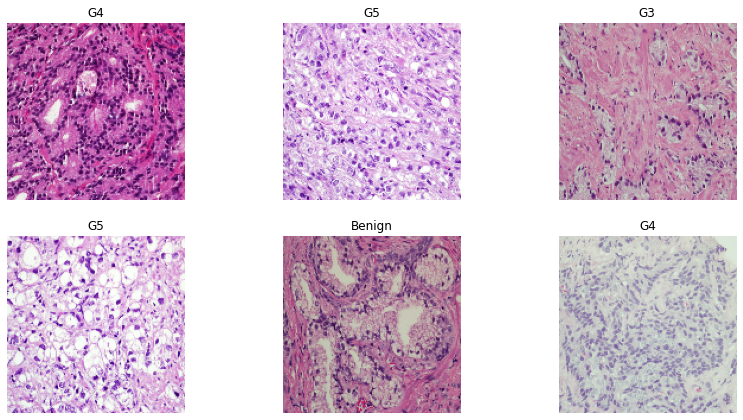

In [11]:
plot_data(validation_generator,7)

**Great, now that the data is ready let's train our model**

<a id="3"></a>
<h1 style='background:#fad25a;padding-top:17px; border:0; color:black'><center>Model Implementations</center></h1> 
    
# Model Implementations

In [12]:
inputs = tf.keras.layers.Input(shape=(150,150,3))
x =  tf.keras.layers.Conv2D(32, (3,3), activation='relu')(inputs)
x = tf.keras.layers.Conv2D(64, (3,3), activation='relu')(x)
x = tf.keras.layers.MaxPooling2D(2,2)(x)

x = tf.keras.layers.Conv2D(64, (3,3), activation='relu')(x)
x = tf.keras.layers.Conv2D(128, (3,3), activation='relu')(x)
x = tf.keras.layers.MaxPooling2D(2,2)(x)

x = tf.keras.layers.Conv2D(128, (3,3), activation='relu')(x)
x = tf.keras.layers.Conv2D(256, (3,3), activation='relu')(x)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = Dense(1024,activation='relu')(x)
x = tf.keras.layers.Dense(4, activation='softmax')(x) # 4 classes

model = Model(inputs=inputs, outputs=x)

2023-01-08 12:08:12.361748: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-08 12:08:12.365514: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-08 12:08:12.366308: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-08 12:08:12.367539: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [13]:
model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.001),
              loss='sparse_categorical_crossentropy',
              metrics = ['accuracy'])

In [14]:
r = model.fit(
        train_generator,
        epochs=10,# Training longer could yield better results
        validation_data=validation_generator)

2023-01-08 12:08:17.903044: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/10


2023-01-08 12:08:21.874834: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


3/3 [==============================] - 19s 4s/step - loss: 1.4081 - accuracy: 0.2339 - val_loss: 1.5120 - val_accuracy: 0.2727
Epoch 2/10
3/3 [==============================] - 8s 3s/step - loss: 1.4171 - accuracy: 0.2515 - val_loss: 1.3802 - val_accuracy: 0.2727
Epoch 3/10
3/3 [==============================] - 6s 2s/step - loss: 1.3851 - accuracy: 0.2456 - val_loss: 1.3810 - val_accuracy: 0.2727
Epoch 4/10
3/3 [==============================] - 6s 2s/step - loss: 1.3822 - accuracy: 0.2924 - val_loss: 1.3774 - val_accuracy: 0.2727
Epoch 5/10
3/3 [==============================] - 7s 2s/step - loss: 1.5769 - accuracy: 0.3041 - val_loss: 1.3805 - val_accuracy: 0.2273
Epoch 6/10
3/3 [==============================] - 7s 2s/step - loss: 1.3810 - accuracy: 0.2632 - val_loss: 1.3704 - val_accuracy: 0.2727
Epoch 7/10
3/3 [==============================] - 7s 2s/step - loss: 1.4283 - accuracy: 0.3216 - val_loss: 1.3765 - val_accuracy: 0.2727
Epoch 8/10
3/3 [==============================] - 6

In [15]:
loss_val, acc_val = model.evaluate(validation_generator)
print("Validation: accuracy = %f  ;  loss_v = %f" % (acc_val, loss_val))

1/1 [==============================] - 1s 893ms/step - loss: 1.3589 - accuracy: 0.2727
Validation: accuracy = 0.272727  ;  loss_v = 1.358891


In [16]:
history1 = pd.DataFrame(r.history)
history1.tail()

loss  accuracy  val_loss  val_accuracy
5  1.380980  0.263158  1.370397      0.272727
6  1.428345  0.321637  1.376514      0.272727
7  1.359403  0.309942  2.092219      0.272727
8  1.558863  0.263158  1.366527      0.272727
9  1.366713  0.286550  1.358891      0.272727

<a id="4"></a>
<h1 style='background:#fad25a;padding-top:17px; border:0; color:black'><center>Transfer Learning</center></h1> 
    
# Transfer Learning
#### We'll be using InceptionV3

In [17]:
#Load Model
inception = tf.keras.applications.InceptionV3(weights='imagenet',include_top=False,input_shape=(150,150,3))

for layer in inception.layers[:-10]:
    layer.trainable = False # Freeze weights of all layers till except the last 10
    
last_layer = inception.get_layer('mixed7')

print('last layer output shape: ', last_layer.output_shape)

layer_output = last_layer.output


87924736/87910968 [==============================] - 3s 0us/step
last layer output shape:  (None, 7, 7, 768)


In [18]:
x = Flatten()(layer_output)
x = BatchNormalization()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.2)(x)
predictions = Dense(4, activation='softmax')(x) # 4 classes
model = Model(inception.input, predictions)

In [19]:
print(len(model.layers))

234


In [20]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d_6 (Conv2D)               (None, 74, 74, 32)   864         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 74, 74, 32)   96          conv2d_6[0][0]                   
__________________________________________________________________________________________________
activation (Activation)         (None, 74, 74, 32)   0           batch_normalization[0][0]        
____________________________________________________________________________________________

In [21]:
def scheduler(epoch, lr):
    
    if epoch < 20:
        return lr
    else:
        return lr * tf.math.exp(-0.2)
    
callback = tf.keras.callbacks.LearningRateScheduler(scheduler) # set the callback to our scheduler function

In [22]:
# Set the training parameters
model.compile(optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.0001), 
              loss = 'sparse_categorical_crossentropy', 
              metrics = ['accuracy'])

In [23]:
history = model.fit(
            train_generator,
            validation_data = validation_generator,
            epochs = 50,callbacks=[callback])

Epoch 1/50
3/3 [==============================] - 12s 3s/step - loss: 2.1062 - accuracy: 0.4386 - val_loss: 2.5406 - val_accuracy: 0.4091
Epoch 2/50
3/3 [==============================] - 7s 2s/step - loss: 1.5144 - accuracy: 0.6725 - val_loss: 1.2972 - val_accuracy: 0.5909
Epoch 3/50
3/3 [==============================] - 7s 2s/step - loss: 1.0835 - accuracy: 0.6784 - val_loss: 0.9871 - val_accuracy: 0.5909
Epoch 4/50
3/3 [==============================] - 6s 2s/step - loss: 0.7750 - accuracy: 0.7310 - val_loss: 1.2113 - val_accuracy: 0.5455
Epoch 5/50
3/3 [==============================] - 7s 2s/step - loss: 0.7266 - accuracy: 0.7661 - val_loss: 0.8543 - val_accuracy: 0.6818
Epoch 6/50
3/3 [==============================] - 7s 3s/step - loss: 0.5821 - accuracy: 0.8246 - val_loss: 0.7675 - val_accuracy: 0.6818
Epoch 7/50
3/3 [==============================] - 6s 2s/step - loss: 0.5839 - accuracy: 0.7836 - val_loss: 0.5732 - val_accuracy: 0.7727
Epoch 8/50
3/3 [========================

<a id="4"></a>
<h1 style='background:#fad25a;padding-top:17px; border:0; color:black'><center>Evaluation</center></h1> 
    
# Evaluation

In [24]:
loss_val, acc_val = model.evaluate(validation_generator)
print("Validation: accuracy = %f  ;  loss_v = %f" % (acc_val, loss_val))
model.save("inceptionv3_model.h5")

1/1 [==============================] - 1s 910ms/step - loss: 0.4784 - accuracy: 0.8182
Validation: accuracy = 0.818182  ;  loss_v = 0.478374


2023-01-08 12:15:32.753862: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 154140672 exceeds 10% of free system memory.
2023-01-08 12:15:33.172034: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 154140672 exceeds 10% of free system memory.


## Visualize the predicitons

In [25]:
def plot_prediction(generator, n_images):
    """
    Test the model on random predictions
    Args:
    generator: a generator instance
    n_images : number of images to plot

    """
    i = 1
    # Get the images and the labels from the generator
    images, labels = generator.next()
    # Gets the model predictions
    preds = model.predict(images)
    predictions = np.argmax(preds, axis=1)
    labels = labels.astype('int32')
    plt.figure(figsize=(14, 15))
    for image, label in zip(images, labels):
        plt.subplot(4, 3, i)
        plt.imshow(image)
        if predictions[i] == labels[i]:
            title_obj = plt.title(class_names[label])
            plt.setp(title_obj, color='g') 
            plt.axis('off')
        else:
            title_obj = plt.title(class_names[label])
            plt.setp(title_obj, color='r') 
            plt.axis('off')
        i += 1
        if i == n_images:
            break
    
    plt.show()

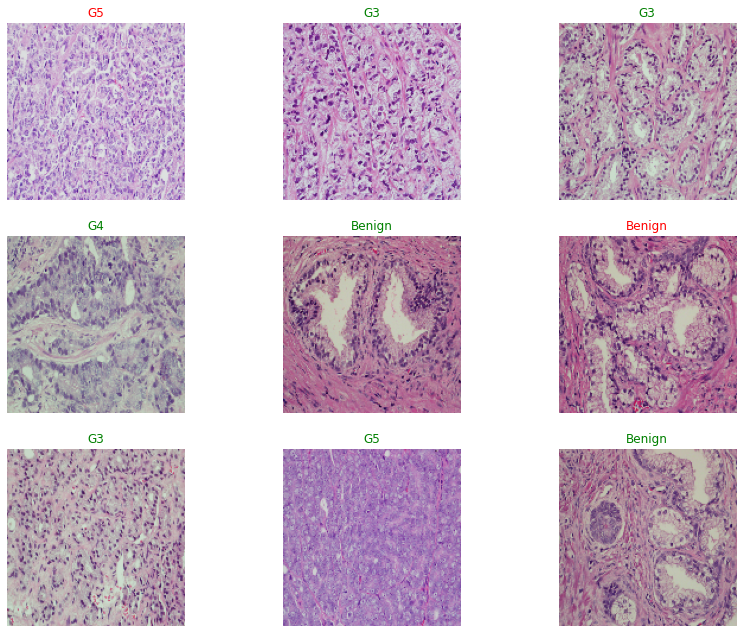

In [26]:
plot_prediction(validation_generator, 10)

## View saliency map
#### Saliency activation maps is used to find which parts the model was paying attention to while classifying the image

In [27]:
images, labels =  validation_generator.next()

In [28]:
def calculate_gradients(images, labels, index):
    """
    Computes gradient of the loss with respect to the input image
    
    Args:
    Images: numpy array containing images of shape (n,150,150,3)
    labels: numpy array containing labels shape(n,)
    index: index of the image
    """
    # get image of the given index and add 1 to it's first dimension
    image = np.expand_dims(images[index],axis=0)
    #convert image to tensor
    image_tensor = tf.convert_to_tensor(image)
    # get the class of the given label and convert it to an integer
    class_index = int(labels[index])
    # one hot encode the labels 
    true_value = tf.one_hot([class_index] * image.shape[0], 4)

    # compute the gradient of the loss
    with tf.GradientTape() as tape:
        # Watch the input image
        tape.watch(image_tensor)
        # Generate predictions
        pred  = model(image_tensor)
        # Compute loss
        loss = tf.keras.losses.categorical_crossentropy(true_value, pred)
    # Get the gradient with respect to the image
    gradients = tape.gradient(loss, image_tensor)
    
    grey_scale_gradients = tf.reduce_sum(tf.abs(gradients),axis=-1)
    normalized_gradients = (255*(grey_scale_gradients - tf.reduce_min(grey_scale_gradients))/
                           (tf.reduce_max(grey_scale_gradients) - tf.reduce_min(grey_scale_gradients)))
    
    normalized_gradients = tf.squeeze(normalized_gradients)
    normalized_gradients = tf.cast(normalized_gradients, tf.uint8)
    return normalized_gradients,pred

In [29]:
def show_saliency(images, labels, n_images):
    """
    plot saliency maps
    Args:
    Images: numpy array containing images of shape (n,150,150,3)
    labels: numpy array containing labels shape(n,)
    n_images: number of images to plot
    """
    # Loop for number of images specified
    for i in range(n_images):
        # Computes gradient of the loss with respect to the input image
        gradients,prediction = calculate_gradients(images, labels, i)
        prediction = np.argmax(prediction)
        # Colorize greyscale gradients
        gradient_color = cv2.applyColorMap(gradients.numpy(), cv2.COLORMAP_HOT)
        #Normalize the colored gradients
        gradient_color = gradient_color / 255.0
        # Super impose colored gradients on the image
        super_imposed = cv2.addWeighted(images[i], 0.6, gradient_color, 0.5, 0.1, dtype = cv2.CV_64F)
        print('Predicted Class: ' +str(class_names[prediction]+",\t"+ f'True Class: {class_names[int(labels[i])]}'))
        plt.figure(figsize=(8, 8))
        plt.imshow(super_imposed)
        plt.axis('off')
        plt.show()

Predicted Class: G5,	True Class: G5


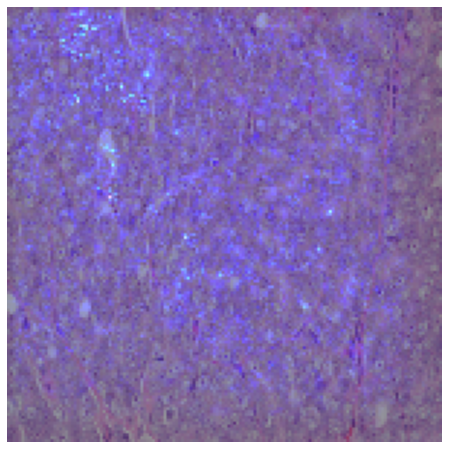

Predicted Class: Benign,	True Class: Benign


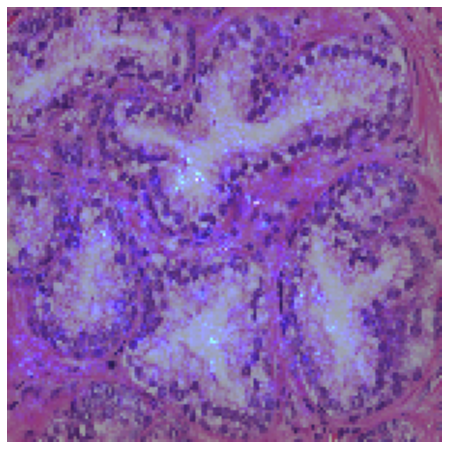

Predicted Class: Benign,	True Class: Benign


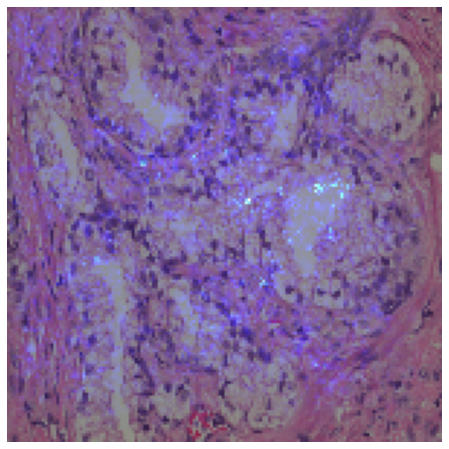

Predicted Class: G4,	True Class: G3


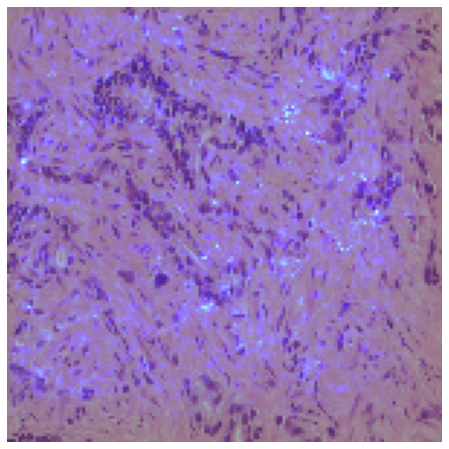

Predicted Class: G5,	True Class: G5


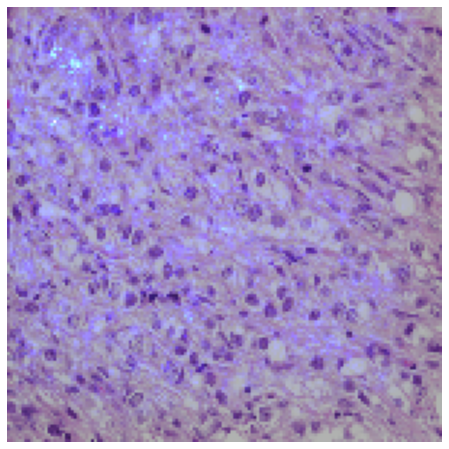

In [30]:
show_saliency(images, labels, 5)

## Visualize training process

In [31]:
results = pd.DataFrame(history.history)
results.tail()

loss  accuracy  val_loss  val_accuracy            lr
45  0.208109  0.906433  0.473216      0.818182  5.516567e-07
46  0.114334  0.947368  0.472520      0.818182  4.516583e-07
47  0.141639  0.941520  0.474838      0.818182  3.697866e-07
48  0.145702  0.953216  0.476807      0.818182  3.027557e-07
49  0.094452  0.970760  0.478374      0.818182  2.478754e-07

In [32]:
fig = px.line(results,y=[results['accuracy'],results['val_accuracy']],template="plotly_dark",color_discrete_sequence=['#F67280','#DD2706'])
fig.update_layout(   
    title_font_color="#41BEE9", 
    xaxis=dict(color="#41BEE9",title='Epochs'), 
    yaxis=dict(color="#41BEE9")
 )
fig.show()

In [33]:
fig = px.line(results,y=[results['loss'],results['val_loss']],template="plotly_dark",color_discrete_sequence=['#F67280','#DD2706'])
fig.update_layout(   
    title_font_color="#41BEE9", 
    xaxis=dict(color="#41BEE9",title='Epochs'), 
    yaxis=dict(color="#41BEE9")
 )
fig.show()

<a id="5"></a>
<h1 style='background:#fad25a;padding-top:17px; border:0; color:black'><center>Conclusion</center></h1> 
    
# Conclusion

**We were able to achieve 93 training accuracy and 81 validation accuracy**


**This seems much better than the original results from the simple CNN here**